# Test Zipcode Encoding

#### Import

In [1]:
# import tool set
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from fast_ml.model_development import train_valid_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from basic_data_prep import import_data, prep_data, prep_data_long
from model_evaluation import execute_cross_validate, eval_on_set, get_split

In [2]:
# Get data from CSV
df = import_data()
df.head(3)

id        date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  7129300520  2014-10-13         3       1.00         1180      5650     1.0   
1  6414100192  2014-12-09         3       2.25         2570      7242     2.0   
2  5631500400  2015-02-25         2       1.00          770     10000     1.0   

   waterfront  view  condition  ...  sqft_above  sqft_basement  yr_built  \
0           0     0          3  ...        1180              0      1955   
1           0     0          3  ...        2170            400      1951   
2           0     0          3  ...         770              0      1933   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15   price  
0             0    98178  47.5112 -122.257           1340        5650  221900  
1          1991    98125  47.7210 -122.319           1690        7639  538000  
2             0    98028  47.7379 -122.233           2720        8062  180000  

[3 rows x 21 columns]

In [3]:
from model_evaluation import get_split, cross_val_and_eval

In [4]:
df = prep_data()
X_train, y_train, X_val, y_val, *other = get_split(df)
results = cross_val_and_eval(LinearRegression(), X_train, y_train, X_val, y_val, folds=5)

5-fold Cross Validation using only training data:
 {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}
Performance on validation set:
{'mae': 123285.864, 'rmse': 198615.523, 'rsquare': 0.693, 'adj_rsquare': 0.692}


#### Baseline results
5-fold Cross Validation using only training data:  
- {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}  

Performance on validation set:  
- {'mae': 123285.864, 'rmse': 198615.523, 'rsquare': 0.693, 'adj_rsquare': 0.692}

In [5]:
from outlier_handling import remove_outliers

### Using Zipcode vs. Kmeans Clustering of Latitude and Longitude <a class="anchor" id="kmeans"></a>

In [10]:
# setup pipeline
def run_pipeline(df, cat_features, num_features, test_eval=True):
    
    # TRANSFORMERS      
    cat_transformer = ('cat', 
                       OneHotEncoder(handle_unknown='ignore'),    # can hereby handle unfamiliar zip codes in test data set
                       cat_features) 
    
    num_transformer = ('num', 
                       StandardScaler(), 
                       num_features)
            
    preprocessor = ColumnTransformer(transformers= [cat_transformer, num_transformer], 
                                     remainder='passthrough')   # 'remainder' allows columns that are not explicitly mentioned to be passed through
    
    # PIPELINE STEPS
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', LinearRegression())
    ])
    
    # SPLIT DATA
    X = df.drop('price', axis = 1)
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(X_train.shape, X_test.shape)

    # CROSS-VALIDATE (only uses training data)
    cross_val_scores = execute_cross_validate(pipeline, X_train, y_train, folds=5)


    # EVALUATE ON TEST SET
    if test_eval==True:
        
        test_set_scores = eval_on_set(pipeline, X_train, y_train, X_test, y_test, set_type='test')    
        return cross_val_scores, test_set_scores, pipeline, #val_set_scores, 
    else:
        return cross_val_scores, pipeline, #val_set_scores,

#### Zipcode

In [11]:
# Test model performance with outlier removal and encoding of zipcode
cat_features = ['zipcode']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']

df_sans_outliers = remove_outliers(prep_data())
result = run_pipeline(df_sans_outliers, cat_features, num_features)

(14431, 18) (6186, 18)
5-fold Cross Validation using only training data:
 {'mean_mae': 80036.391, 'mean_rmse': 125298.108, 'mean_rsquare': 0.81, 'mean_adj_rsquare': 0.809}
Performance on test set:
{'mae': 81921.178, 'rmse': 126986.912, 'rsquare': 0.81, 'adj_rsquare': 0.809}


#### Notes:
- encoding zipcode in addition to removing outliers leads to significant improvement across all metrics :
    - performance with encoded zip code and outlier removal: {'mean_mae': 79786.76, 'mean_rmse': 123410.56, 'mean_rsquare': 0.814, 'mean_adj_rsquare': 0.814}
    - performance with only outlier removal: {'mean_mae': 107803.888, 'mean_rmse': 160393.059, 'mean_rsquare': 0.686, 'mean_adj_rsquare': 0.686}
    - comparison to baseline: {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}

In [9]:
# Test with adjusted pipeline

from pipeline import test_pipeline

# Test model performance with outlier removal but no additional processing
df_sans_outliers = remove_outliers(prep_data())


cat_features = ['zipcode']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']

result = test_pipeline(df_sans_outliers, cat_features, num_features, cluster=False)

cat_features before if statement: ['zipcode']
cat_features after if statement: ['zipcode']
(14431, 16) (6186, 16)
5-fold Cross Validation using only training data:
 {'mean_mae': 79951.691, 'mean_rmse': 125267.138, 'mean_rsquare': 0.81, 'mean_adj_rsquare': 0.81}


#### Notes:
- removing outliers has a positive impact on MAE and RMSE but negatively impacts (adjusted) r2:
    - model performance with outlier removal: {'mean_mae': 109024.055, 'mean_rmse': 163945.9, 'mean_rsquare': 0.678, 'mean_adj_rsquare': 0.678}
    - comparison to baseline: {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}

In [12]:
from experimental import add_kmeans_clusters

<Axes: xlabel='long', ylabel='lat'>

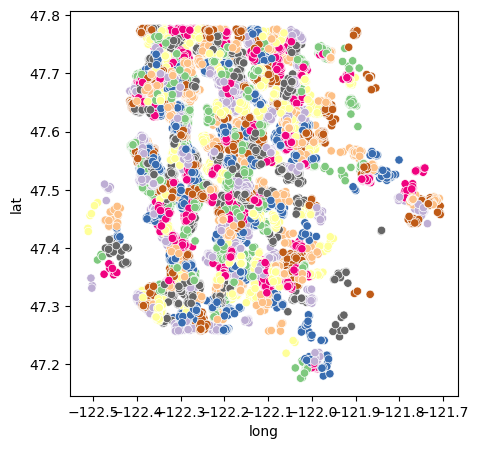

In [13]:
# Test creation of clusters with Kmeans
df_sans_outliers = remove_outliers(prep_data())
df_geo_clusters = add_kmeans_clusters(df_sans_outliers, clusters=500, drop_cols=False)

# Plot clusters
plt.figure(figsize = (5,5))
sns.scatterplot(x=df_geo_clusters['long'], y=df_geo_clusters['lat'], hue=df_geo_clusters['geo_cluster'], palette='Accent', legend = False)

In [14]:
from pipeline import test_pipeline

# Test performance with clustering
cat_features = ['geo_cluster']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']

df_sans_outliers = remove_outliers(prep_data())

# we set cluster to 'True' and provide the desired number of clusters
result = test_pipeline(df=df_sans_outliers, 
                       cluster= True, 
                       n_clusters = 500, 
                       cat_features=cat_features, 
                       num_features=num_features)

cat_features before if statement: ['geo_cluster']
cat_features after if statement: ['geo_cluster']
(14431, 17) (6186, 17)
5-fold Cross Validation using only training data:
 {'mean_mae': 74735.097, 'mean_rmse': 117693.186, 'mean_rsquare': 0.832, 'mean_adj_rsquare': 0.832}
